In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

# Uncovering World Events using Twitter Hashtags

## ... and learning about Spark `DataFrames` along the way

In this notebook, we will use temporal information about Twitter hashtags to discover trending topics and potentially uncover world events as they occurred. You've already used this dataset in a previous homework, but here we will be working with it in Apache Spark.

### Hashtags

The idea here is that when an event is happening and people are having a conversation about it on Twitter, a set of uniform hashtags that represent the event spontaneously evolves. Twitter users then use those hashtags to communicate with one another. Some hashtags, like `#RT` for "retweet" or just `#retweet` are used frequently and don't tell us much about what is going on. But a sudden appearance of a hashtag like `#oscars` probably indicates that the oscars are underway. For a particularly cool example of this type of analysis, check out [this blog post about earthquake detection using Twitter data](https://blog.twitter.com/official/en_us/a/2015/usgs-twitter-data-earthquake-detection.html) (although they search the text and not necessarily hashtags).

## Initialize the `SparkSession`

In [2]:
import getpass
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("yarn") \
    .appName('twitter-{0}'.format(getpass.getuser())) \
    .config('spark.executor.memory', '4g') \
    .config('spark.executor.instances', '5') \
    .config('spark.port.maxRetries', '100') \
    .getOrCreate()

In [3]:
spark

## Set up the hashtag `DataFrame` (10 points / 60)

We have prepared the hashtag data spanning the time from April-July 2016. This is a significant time in modern European history, e.g. see [Brexit](https://en.wikipedia.org/wiki/Brexit). Lets see if we can see any interesting trends about these events in the Twitter data. 

In [4]:
from datetime import datetime

import pyspark.sql.functions as functions

### DONE (1 point/10)

Load the **parquet** data from `/datasets/twitter/parquet/2016-hashtags-timestamp` into a Spark dataframe using the appropriate `SparkSession` method. 

Look at the first few rows of the dataset - note the timestamp and its units!

In [5]:
# Load the file
df = spark.read.parquet('/datasets/twitter/parquet/2016-hashtags-timestamp')
df.show()

+------------+----+------------------+
|   timestamp|lang|           hashtag|
+------------+----+------------------+
|1.46152973E9|  ar|  كلنا_لله_والرسول|
|1.46154317E9|  ja|             vジャンプ|
| 1.4615296E9|  pt|     gameofthrones|
|1.46152832E9|  tr|            itiraf|
|1.46154573E9|  ko|                더쇼|
|1.46154483E9| und|              ford|
| 1.4615433E9|  en|        stanleycup|
|1.46152934E9|  ru|           новости|
|1.46154573E9|  en|        bsoulradio|
|1.46154496E9|  en|tsouitscomplicated|
|1.46152973E9|  ja|            rezero|
|1.46154317E9|  en|              star|
|1.46154253E9|  ko|              성인자료|
| 1.4615296E9|  ar|               أخر|
|1.46153152E9|  tr|      aşıkolanadam|
| 1.4615296E9|  ja|              相互限定|
|1.46152896E9|  en|              vibe|
|1.46154458E9|  en|     gameofthrones|
|1.46154317E9|  ja|              予約投稿|
|1.46154317E9|  ja|               傷物語|
+------------+----+------------------+
only showing top 20 rows



### User-defined functions

A neat trick of spark dataframes is that you can essentially use something very much like an RDD `map` method but without switching to the RDD. If you are familiar with database languages, this works very much like e.g. a user-defined function in SQL. 

So, for example, if we wanted to make a user-defined python function that returns the hashtags in lowercase, we could do something like this:

In [6]:
@functions.udf
def lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

The @functions.udf is a "decorator" -- this is really handy python syntactic sugar and in this case is equivalent to:

```
def lowercase(text):
    return text.lower()
    
lowercase = functions.udf(lowercase)
```

It basically takes our function and adds to its functionality. In this case, it registers our function as a pyspark dataframe user-defined function (UDF).

Using these UDFs is very straightforward and analogous to other Spark dataframe operations. For example:

In [7]:
df.select(lowercase(df.hashtag)).show()

+------------------+
|lowercase(hashtag)|
+------------------+
|  كلنا_لله_والرسول|
|             vジャンプ|
|     gameofthrones|
|            itiraf|
|                더쇼|
|              ford|
|        stanleycup|
|           новости|
|        bsoulradio|
|tsouitscomplicated|
|            rezero|
|              star|
|              성인자료|
|               أخر|
|      aşıkolanadam|
|              相互限定|
|              vibe|
|     gameofthrones|
|              予約投稿|
|               傷物語|
+------------------+
only showing top 20 rows



Using a framework like Spark is all about understanding the ins and outs of how it functions and knowing what it offers. One of the cool things about the dataframe API is that many functions are already defined for you (turning strings into lowercase being one of them). 

### DONE (2 points / 10)

Find the Spark python API documentation. Look for the `sql` section and find the listing of `sql.functions`. Repeat the above (turning hashtags into lowercase) but use the built-in function.

In [8]:
df.select(functions.lower(df.hashtag)).show()

+------------------+
|    lower(hashtag)|
+------------------+
|  كلنا_لله_والرسول|
|             vジャンプ|
|     gameofthrones|
|            itiraf|
|                더쇼|
|              ford|
|        stanleycup|
|           новости|
|        bsoulradio|
|tsouitscomplicated|
|            rezero|
|              star|
|              성인자료|
|               أخر|
|      aşıkolanadam|
|              相互限定|
|              vibe|
|     gameofthrones|
|              予約投稿|
|               傷物語|
+------------------+
only showing top 20 rows



We'll work with a combination of these built-in functions and user-defined functions for the remainder of this homework. 

### DONE (7 points/10)

Create `english_df` consisting of **lowercase** hashtags from only english-language tweets. In addition, convert the timestamp to a more readable format like this and name the column `date`:

```
2016-04-01 08:41:00
```

In [9]:
# Selection only hashtags in english
english_df = df.select(df.timestamp, df.lang, df.hashtag).filter(df.lang == 'en')

# Add hashtag column
english_df = english_df.withColumn('hashtag', functions.lower(df.hashtag))

# Add date column using the timestamp
english_df = english_df.withColumn('date', functions.from_unixtime(df.timestamp, 'yyyy-MM-dd HH:mm:ss'))

# Show the result
english_df.show(5)

+------------+----+------------------+-------------------+
|   timestamp|lang|           hashtag|               date|
+------------+----+------------------+-------------------+
| 1.4615433E9|  en|        stanleycup|2016-04-25 02:14:56|
|1.46154573E9|  en|        bsoulradio|2016-04-25 02:55:28|
|1.46154496E9|  en|tsouitscomplicated|2016-04-25 02:42:40|
|1.46154317E9|  en|              star|2016-04-25 02:12:48|
|1.46152896E9|  en|              vibe|2016-04-24 22:16:00|
+------------+----+------------------+-------------------+
only showing top 5 rows



Your `english_df` should look something like this:

```
+------------+----+------------------+-------------------+
|   timestamp|lang|           hashtag|               date|
+------------+----+------------------+-------------------+
| 1.4615433E9|  en|        stanleycup|2016-04-25 02:14:56|
|1.46154573E9|  en|        bsoulradio|2016-04-25 02:55:28|
|1.46154496E9|  en|tsouitscomplicated|2016-04-25 02:42:40|
|1.46154317E9|  en|              star|2016-04-25 02:12:48|
|1.46152896E9|  en|              vibe|2016-04-24 22:16:00|
+------------+----+------------------+-------------------+
```

## Twitter hashtag trends (50 points / 60)

In this section we will try to do a slightly more complicated analysis of the tweets. Our goal is to get an idea of tweet frequency as a function of time for certain hashtags. 

Lets build this up in steps. First, lets see how we can start to organize the tweets by their timestamps. 

As a first easy example, lets say we just want to count the number of tweets per minute over the entire span of our data. For this, we first need a "global" minute value, e.g. "minute of the year" or something similar. 

Spark provides us with some handy built-in dataframe functions that are made for transforming date and time fields. 

Have a look [here](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) to see the whole list of custom dataframe functions - you will need to use them to complete the next set of TODO items.

Note that the functions can be combined. Consider the following dataframe and its transformation:

In [10]:
from pyspark.sql import Row

In [11]:
# create a sample dataframe with one column "degrees" going from 0 to 180
test_df = spark.createDataFrame(spark.sparkContext.range(180).map(lambda x: Row(degrees=x)), ['degrees'])

# define a function "sin_rad" that first converts degrees to radians and then takes the sine using built-in functions
sin_rad = functions.sin(functions.radians(test_df.degrees))

# show the result
test_df.select(sin_rad).show()

+---------------------+
|SIN(RADIANS(degrees))|
+---------------------+
|                  0.0|
|  0.01745240643728351|
|  0.03489949670250097|
|  0.05233595624294383|
|   0.0697564737441253|
|  0.08715574274765817|
|  0.10452846326765346|
|  0.12186934340514748|
|  0.13917310096006544|
|  0.15643446504023087|
|  0.17364817766693033|
|   0.1908089953765448|
|  0.20791169081775931|
|  0.22495105434386498|
|  0.24192189559966773|
|  0.25881904510252074|
|  0.27563735581699916|
|   0.2923717047227367|
|   0.3090169943749474|
|   0.3255681544571567|
+---------------------+
only showing top 20 rows



### DataFrames `groupBy`

We used `groupBy` already in the previous notebook, but here we will take more advantage of its features. 

One important thing to note is that unlike other RDD or DataFrame transformations, the `groupBy` does not return another DataFrame, but a `GroupedData` object instead, with its own methods. These methods allow you to do various transformations and aggregations on the data of the grouped rows. 

Conceptually the procedure is a lot like this:

![groupby](https://i.stack.imgur.com/sgCn1.jpg)

The column that is used for the `groupBy` is the `key` - once we have the values of a particular key all together, we can use various aggregation functions on them to generate a transformed dataset. In this example, the aggregation function is a simple `sum`. In the simple procedure below, the `key` will be the hashtag.

### DONE (1 point / 50)

Calculate the top five most common hashtags in the whole english-language dataset.

This should be your result:

```
+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800829|
|veranomtv2016|539028|
| iheartawards|447648|
|  bestfanarmy|429739|
|   teenchoice|345231|
+-------------+------+
```

In [12]:
most_comm_hashtag = english_df.groupBy('hashtag').count().sort('count', ascending=False).limit(5)
most_comm_hashtag.show()

+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800829|
|veranomtv2016|539028|
| iheartawards|447648|
|  bestfanarmy|429739|
|   teenchoice|345231|
+-------------+------+



## Daily hashtag trends

Now we will start to complicate the analysis a bit. Remember, our goal is to uncover trending topics on a timescale of a few days. A much needed column then is simply `day`. To convert the date string into day-of-year, you can use the built-in [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) function. 

In the subsequent sections we will then not only see which hashtags are globally most popular, but which ones experience the biggest changes in popularity - those are the "trending" topics. If there is suddenly a substantial increase of a hashtag over a matter of a day or two, it may signify an event taking place. 

### DONE (2 points / 50)

Create a dataframe called `daily_hashtag` that includes the columns `month`, `week`, `day` and `hashtag`. Use the `english_df` you made above to start, and make sure you find the appropriate spark dataframe functions to make your life easier. Show the result.

Try to match this view:

```
+-----+----+---+------------------+
|month|week|day|           hashtag|
+-----+----+---+------------------+
|    4|  17|116|        stanleycup|
|    4|  17|116|        bsoulradio|
|    4|  17|116|tsouitscomplicated|
|    4|  17|116|              star|
|    4|  16|115|              vibe|
+-----+----+---+------------------+
```

In [13]:
daily_hashtag = english_df.withColumn('d', functions.to_date('date', 'yyyy-MM-dd HH:mm:ss'))\
                          .select(functions.month('d').alias('month'),
                                  functions.weekofyear('d').alias('week'),
                                  functions.dayofyear('d').alias('day'),
                                  'hashtag')
daily_hashtag.show(5)

+-----+----+---+------------------+
|month|week|day|           hashtag|
+-----+----+---+------------------+
|    4|  17|116|        stanleycup|
|    4|  17|116|        bsoulradio|
|    4|  17|116|tsouitscomplicated|
|    4|  17|116|              star|
|    4|  16|115|              vibe|
+-----+----+---+------------------+
only showing top 5 rows



### DONE (2 points / 50)

Now we want to calculate the number of times a hashtag is used per day. Sort in descending order of daily counts and show the result. Call the resulting dataframe `day_counts`.

Your output should look like this:

```
+---+------------+----+------+
|day|     hashtag|week| count|
+---+------------+----+------+
| 94|iheartawards|  13|208326|
| 94| bestfanarmy|  13|202267|
| 93|iheartawards|  13|133463|
| 93| bestfanarmy|  13|131405|
| 94|     5sosfam|  13| 81002|
+---+------------+----+------+
```

<div class="alert alert-info">
<p>Make sure you use `cache()` when you create `day_counts` because we will need it in the steps that follow!</p>
</div>

In [14]:
day_counts = daily_hashtag.groupBy('day', 'hashtag', 'week').count().sort('count', ascending=False).cache()
day_counts.show(5)

+---+------------+----+------+
|day|     hashtag|week| count|
+---+------------+----+------+
| 94|iheartawards|  13|208326|
| 94| bestfanarmy|  13|202267|
| 93|iheartawards|  13|133463|
| 93| bestfanarmy|  13|131405|
| 94|     5sosfam|  13| 81002|
+---+------------+----+------+
only showing top 5 rows



### DONE (2 points / 50)

To get an idea of which hashtags stay popular for several days, calculate the average number of daily occurences for each week. Hint: use the `week` column we created above. Sort in descending order and show the top 20.

In [15]:
day_counts.groupBy('week', 'hashtag').mean('count').sort('avg(count)', ascending=False).show()

+----+-----------------+------------------+
|week|          hashtag|        avg(count)|
+----+-----------------+------------------+
|  13|     iheartawards|          128017.0|
|  13|      bestfanarmy|125075.66666666667|
|  29|       mtvhottest|           51935.0|
|  30|       mtvhottest| 47960.71428571428|
|  13|          5sosfam|           46847.0|
|  13|      harmonizers|42939.333333333336|
|  13|     directioners|32562.333333333332|
|  19|       teenchoice|20124.428571428572|
|  25|    veranomtv2016|18096.285714285714|
|  26|    veranomtv2016|17386.571428571428|
|  15|aldub9thmonthsary|16190.666666666666|
|  27|    veranomtv2016| 14033.42857142857|
|  28|       mtvhottest|13168.857142857143|
|  30|    veranomtv2016|12528.142857142857|
|  23|     ripchristina|           12017.0|
|  23|    mtvawardsstar|12010.333333333334|
|  27|    altonsterling|           10291.4|
|  30|     demsinphilly|           10049.0|
|  14|     iheartawards| 8853.285714285714|
|  31|       mtvhottest|        

### Using `Window` functions 

Window functions are another awesome feature of dataframes. They allow users to accomplish complex tasks using very concise and simple code. 

Above we computed just the hashtag that had the most occurrences on *any* day. Now lets say we want to know the top tweets for *each* day.  

This is a non-trivial thing to compute and requires "windowing" our data. I recommend reading this [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) to get acquainted with the idea. You can think of a window function as a fine-grained and more flexible `groupBy`. 

There are two things we need to define to use window functions:

1. the "window" to use, based on which columns (partitioning) and how the rows should be ordered 
2. the computation to carry out for each windowed group, e.g. a max, an average etc.

Lets see how this works by example. We will define a window function, `daily_window` that will partition data based on the `day` column. Within each window, the rows will be ordered by the daily hashtag count that we computed above. Finally, we will use the rank function **over** this window to give us the ranking of top tweets. 

In the end, this is a fairly complicated operation achieved in just a few lines of code! (can you think of how to do this with an RDD??)

In [16]:
from pyspark.sql import Window

First, we specify the window function and the ordering:

In [17]:
daily_window = Window.partitionBy('day').orderBy(functions.desc('count'))

The above window function says that we should window the data on the `day` column and order it by count. 

Now we need to define what we want to compute on the windowed data. We will start by just calculating the daily ranking of hashtags, so we can use the helpful built-in `functions.rank()` and sort:

In [18]:
daily_rank = functions.rank() \
                      .over(daily_window) \
                      .alias('rank') \

### DONE (3 points / 50)
Now compute the top five hashtags for each day in our data:

In [19]:
top_hashtags_each_day = day_counts.select('day', 'hashtag', 'count', daily_rank)
top_hashtags_each_day = top_hashtags_each_day.filter(top_hashtags_each_day.rank <= 5).sort('day', 'rank')
top_hashtags_each_day.show()

+---+------------+------+----+
|day|     hashtag| count|rank|
+---+------------+------+----+
| 92|iheartawards| 42262|   1|
| 92| bestfanarmy| 41555|   2|
| 92| harmonizers| 19844|   3|
| 92|     5sosfam| 15138|   4|
| 92|directioners|  6090|   5|
| 93|iheartawards|133463|   1|
| 93| bestfanarmy|131405|   2|
| 93| harmonizers| 54684|   3|
| 93|     5sosfam| 44401|   4|
| 93|directioners| 30902|   5|
| 94|iheartawards|208326|   1|
| 94| bestfanarmy|202267|   2|
| 94|     5sosfam| 81002|   3|
| 94|directioners| 60695|   4|
| 94| harmonizers| 54290|   5|
| 95|iheartawards| 59870|   1|
| 95| bestfanarmy| 52184|   2|
| 95|     5sosfam| 25701|   3|
| 95|wrestlemania| 14913|   4|
| 95| harmonizers| 12980|   5|
+---+------------+------+----+
only showing top 20 rows



###  DONE - Compute the top five trending tweets per week (20 points / 50)
Use window functions (or other techniques!) to produce lists of top few trending tweets for each week. What's a "trending" tweet? Something that seems to be suddenly growing very rapidly in popularity. You should identify "brexit" in week 25 and other events like the death of The Artist Formerly Known as Prince, the Met gala, Euro 2016, the terrorist attacks in Nice, France etc. Make it as simple or as complicated as you want! The final listing should be clear and concise and the flow of your analysis should be easy to follow. If you make an implementation that is not immediately obvious, make sure you provide comments either in markdown cells or in comments in the code itself.

In [20]:
# Use the same principle as above only group by week
week_counts = day_counts.groupBy('week', 'hashtag').sum('count')

# Window to sort the hashtags each week
weekly_window = Window.partitionBy('week').orderBy(functions.desc('sum(count)'))

# Rank function to use
weekly_rank = functions.rank() \
                      .over(weekly_window) \
                      .alias('rank') 

# Top hashtags per week 
top_hashtags_weekly = week_counts.select('week', 'hashtag', 'sum(count)', weekly_rank)

# Take only the 5 best per week
top_hashtags_weekly_5 = top_hashtags_weekly.filter(top_hashtags_weekly.rank <= 5).sort('week', 'rank')

In [21]:
# Show the week count of each hashtag
week_counts.show()

+----+--------------------+----------+
|week|             hashtag|sum(count)|
+----+--------------------+----------+
|  22|                 ymm|       140|
|  29|        retiremccain|       207|
|  16|closeupforeversummer|       744|
|  29|             voltron|       395|
|  30|         singkaraoke|       479|
|  17|     realdonaldtrump|       365|
|  18|     diasemanishoney|       135|
|  13|              manutd|        68|
|  26|           indiegame|       334|
|  16|          listenlive|      1555|
|  21|                   v|       447|
|  24|         donaldtrump|       669|
|  29|           babymetal|       183|
|  20|            branding|       397|
|  26|           happynday|       350|
|  24|                  규현|       220|
|  19|                 fps|       312|
|  28|          asksquawka|        56|
|  13|                girl|       161|
|  23|              disney|       260|
+----+--------------------+----------+
only showing top 20 rows



In [22]:
# Show the week rank of each hashtag
top_hashtags_weekly.show()

+----+--------------------+----------+----+
|week|             hashtag|sum(count)|rank|
+----+--------------------+----------+----+
|  31|          mtvhottest|      8539|   1|
|  31|          teenchoice|      4609|   2|
|  31|dolceamorethegame...|      2997|   3|
|  31|  pushawardslizquens|      2974|   4|
|  31|   aldublolalifeanew|      1498|   5|
|  31|    teenchoiceawards|      1263|   6|
|  31|          sharknado4|      1130|   7|
|  31|            kcon16la|      1114|   8|
|  31| pushawardskathniels|       928|   9|
|  31|pushawardsviceryl...|       845|  10|
|  31|  trumpdebateexcuses|       763|  11|
|  31|   choicemalewebstar|       706|  12|
|  31|         gameinsight|       627|  13|
|  31|             android|       542|  14|
|  31|          nowplaying|       533|  15|
|  31|        androidgames|       523|  16|
|  31|       gurumsgsays4u|       493|  17|
|  31|            bigolive|       414|  18|
|  31|                bb18|       408|  19|
|  31|       nashsnewvideo|     

In [23]:
top_hashtags_weekly_5.filter((top_hashtags_weekly_5['hashtag']).contains('brexit')).show()

+----+-------+----------+----+
|week|hashtag|sum(count)|rank|
+----+-------+----------+----+
|  25| brexit|     49416|   2|
|  26| brexit|     16762|   4|
+----+-------+----------+----+



In [24]:
top_hashtags_weekly_5.filter((top_hashtags_weekly_5['hashtag']).contains('prince')).show()

+----+-------+----------+----+
|week|hashtag|sum(count)|rank|
+----+-------+----------+----+
|  16| prince|     11189|   3|
+----+-------+----------+----+



In [25]:
top_hashtags_weekly_5.filter((top_hashtags_weekly_5['hashtag']).contains('metgala')).show()

+----+-------+----------+----+
|week|hashtag|sum(count)|rank|
+----+-------+----------+----+
|  18|metgala|     24319|   1|
+----+-------+----------+----+



## Plotting the timeseries of hashtag counts and using KMeans clustering

### DONE (10 points / 50)

The lists we obtained above are nice, but lets actually visualize some data. 

1. create a matrix that consists of hashtags as rows and daily counts as columns (hint: use `groupBy` and methods of `GroupedData`). 
2. use the `VectorAssembler` from the ML library to create the feature vector which will consist of daily counts. 

If you extract any of these vectors you will obtain a numpy array that represents the time series of daily counts - plot this time series for a few interesting hashtags you identified above. hint: the `isin` method of DataFrame columns might be useful. 

In [26]:
from pyspark.ml.feature import VectorAssembler

In [27]:
# Create a DataFrame having for column each occurring day in the dataset
day_counts_matrix = day_counts.groupBy('hashtag').pivot('day').agg(functions.first('count')).cache()

In [28]:
# Assembler to create a feature vector using the days as input columns
assembler = VectorAssembler(inputCols=['{0}'.format(i) for i in day_counts_matrix.columns[1:]], 
                            outputCol='features')
# Filter out null values
day_counts_matrix = day_counts_matrix.fillna(0)
features_df = assembler.transform(day_counts_matrix).cache()

In [29]:
features_df.select('features').first()

Row(features=DenseVector([6.0, 4.0, 2.0, 8.0, 5.0, 7.0, 13.0, 11.0, 7.0, 10.0, 9.0, 11.0, 7.0, 4.0, 2.0, 2.0, 3.0, 7.0, 24.0, 5.0, 4.0, 8.0, 0.0, 4.0, 2.0, 4.0, 5.0, 7.0, 26.0, 10.0, 7.0, 3.0, 10.0, 12.0, 8.0, 8.0, 2.0, 6.0, 9.0, 9.0, 3.0, 2.0, 4.0, 1.0, 3.0, 1.0, 8.0, 6.0, 19.0, 2.0, 3.0, 3.0, 5.0, 2.0, 5.0, 6.0, 2.0, 3.0, 5.0, 1.0, 4.0, 7.0, 1.0, 0.0, 4.0, 10.0, 6.0, 1.0, 11.0, 10.0, 1.0, 4.0, 0.0, 2.0, 5.0, 7.0, 4.0, 4.0, 8.0, 5.0, 4.0, 3.0, 1.0, 4.0, 7.0, 2.0, 7.0, 7.0, 2.0, 3.0, 0.0, 1.0, 4.0, 4.0, 8.0, 2.0, 5.0, 3.0, 4.0, 3.0, 4.0, 4.0, 5.0, 1.0, 6.0, 2.0, 11.0, 12.0, 6.0, 3.0, 5.0, 3.0, 6.0, 8.0, 9.0, 4.0, 12.0, 2.0, 1.0]))

In [31]:
# Plot 3 different hashtag trends over the year: prince, brexit, metgala
prince_array = features_df.filter(features_df.hashtag == 'prince').select('features').collect()
brexit_array = features_df.filter(features_df.hashtag == 'brexit').select('features').collect()
metgala_array = features_df.filter(features_df.hashtag == 'metgala').select('features').collect()

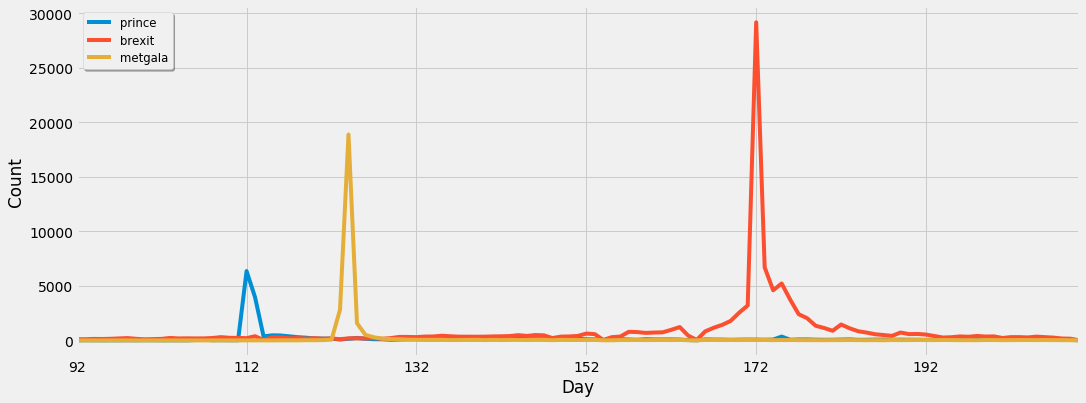

In [54]:
import numpy as np
plt.subplot
plt.figure(figsize=(16, 6))
plt.plot(prince_array[0]['features'], label='prince')
plt.plot(brexit_array[0]['features'], label='brexit')
plt.plot(metgala_array[0]['features'], label='metgala')
plt.xlabel('Day')
plt.ylabel('Count')
locs, labels = plt.xticks()
labels = [int(item)+92 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 118)
legend = plt.legend(loc='upper left', shadow=True, fontsize='small')

### TODO: Use KMeans to cluster hashtags based on the daily count timeseries (10 points / 50)

Use the DataFrame you created above to cluster the hashtag timeseries. Train the model and calculate the cluster membership for all hashtags. Keep in mind that additional data cleaning or filtering might be necessary to get useful results from the model. Show the cluster that includes "brexit" - does it make sense? 

Again, be creative and see if you can get the clustering to give you meaningful hashtag groupings. Make sure you document your process and code and make your final notebook easy to understand even if the result is not optimal or complete. 

In [56]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [100]:
def plot_k_means_elbow(K, distances):
    """ Plot the Elbow curve to help select the 
        number of clusters to use"""
    plt.figure(figsize=(16,6))
    plt.plot(K, distances, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cost')
    plt.show()

In [58]:
costs = []
K = range(2,15)
for k_clusters in K:
    kmeans = KMeans(k=k_clusters)
    model = kmeans.fit(features_df.sample(fraction=0.1, seed=42))
    costs.append(model.computeCost(features_df))

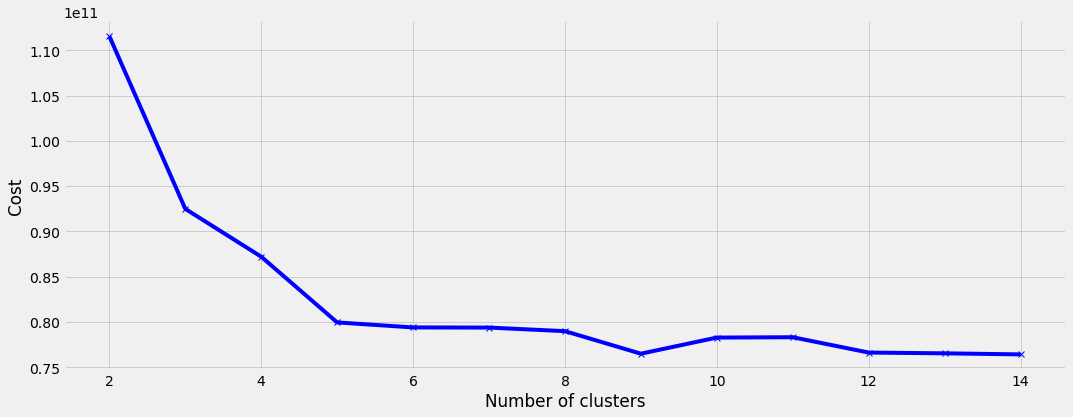

In [101]:
# Plot the elbow curve to get the optimal number of clusters
plot_k_means_elbow(K, costs)

In [64]:
# From the graph above the optimal number of clusters is 8
n_clusters = 5

In [65]:
# Create KMeans model with the optimal number of clusters
kmeans = KMeans(k=n_clusters)
model = kmeans.fit(features_df)

# Get the predictions
predictions = model.transform(features_df)

In [71]:
# Show the cluster membership for all hashtags
hash_pred = predictions.select(['hashtag', 'prediction'])
hash_pred.show()

+--------------------+----------+
|             hashtag|prediction|
+--------------------+----------+
|                cubs|         0|
|getsetforthala57u...|         0|
|chicagogirlsbreak...|         0|
|  labourinforbritain|         0|
|                 kkr|         0|
|               any16|         0|
|              joysms|         0|
|            vote2016|         0|
|            everyday|         0|
|       amberroseshow|         0|
|       werewolfconii|         0|
|            medicare|         0|
|                elsa|         0|
|                wank|         0|
|            lacrosse|         0|
|      personalgrowth|         0|
|                tmnt|         0|
|      thisbudsforyou|         0|
| colliderjedicouncil|         0|
|     thatsprettyneat|         0|
+--------------------+----------+
only showing top 20 rows



In [88]:
# Get the cluster to which belongs brexit
brexit_cluster = hash_pred.filter(hash_pred.hashtag == 'brexit').select('prediction').collect()[0][0]

# Get all hashtags that belong to the same cluster as brexit
cluster_b = spark.createDataFrame(hash_pred.filter(hash_pred.prediction == brexit_cluster) \
                                           .select('hashtag').collect())

# Show the result
cluster_b.show()

+--------------------+
|             hashtag|
+--------------------+
|                cubs|
|getsetforthala57u...|
|chicagogirlsbreak...|
|  labourinforbritain|
|                 kkr|
|               any16|
|              joysms|
|            vote2016|
|            everyday|
|       amberroseshow|
|       werewolfconii|
|            medicare|
|                elsa|
|                wank|
|            lacrosse|
|      personalgrowth|
|                tmnt|
|      thisbudsforyou|
| colliderjedicouncil|
|     thatsprettyneat|
+--------------------+
only showing top 20 rows



After inquisitions we found out the meaning of the following hashtags:
- #labourinforbritain: is the hashtag of the tweeter official account of the campaign to remains in the UE
- #vote2016: can be related to the referendum that took place in june 2016 to exit Europe

Hence we can consider that the cluster make sense.